The network predicts quality scores for the individual repetitions for Exercise 4 - Side Lunge. The input to the network are the raw measurement data with 75 dimensions. This model is trained on the videos used in the UI-PRMD database. And tested with our own videos.

In [1]:
# Import libraries and functions

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import csv
import os,random

# The code is run on a CPU

from keras.models import Model
from keras.layers import Input, Conv1D, LSTM, Dense, Dropout, Activation, Flatten, concatenate, UpSampling1D
from keras.callbacks import EarlyStopping
from keras.optimizers import *
from keras.layers import Lambda

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt

import datetime
now = datetime.datetime.now

C:\Users\Molly Meadows\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
timesteps = 40  # number of timesteps
nrG = 99
nrB = 101   # number of repetitions
n_dim = 75  # dimension of the data sequences

In [3]:
# Import the data
#Correct_data, Correct_label, Incorrect_data, Incorrect_label = DataViconLoad.load_data()
f = open(r'C:/Users/Molly Meadows/OneDrive - University of Idaho/Documents/2023-2024/Capstone Project/26-Physical-Rehabilitation/Retest of videos/same_size_csvs/SideLungeReshaped_correct.csv', 'r')
c = csv.reader(f, delimiter = ',', quoting = csv.QUOTE_NONE)
Correct_data = np.zeros(shape = (nrG, timesteps, n_dim))

# read correct data into array
i = 0
e = 0
for row in c:
    if e >= 99:
        break
    Correct_data[e, :, i % 75] = row
    i += 1
    if i % n_dim == 0:
        e += 1 # episode is done when all 75 features have been read

f.close()

f = open(r'C:/Users/Molly Meadows/OneDrive - University of Idaho/Documents/2023-2024/Capstone Project/26-Physical-Rehabilitation/Retest of videos/same_size_csvs/SideLungeReshaped_incorrect.csv', 'r')
c = csv.reader(f, delimiter = ',', quoting = csv.QUOTE_NONE)
Incorrect_data = np.zeros(shape = (nrB, timesteps, n_dim))

# read incorrect data into array
i = 0
e = 0
for row in c:
    if e >= 101:
        break
    Incorrect_data[e, :, i % 75] = row
    i += 1
    if i % n_dim == 0:
        e += 1
        
f.close()


Correct_label = np.zeros(shape = (nrG, 1))
Correct_label.fill(1)


Incorrect_label = np.zeros(shape = (nrB, 1))
Incorrect_label.fill(0.5)

#print(Correct_label)


# Print the size of the data 
print(Correct_data.shape, 'correct sequences')
print(Correct_label.shape, 'correct labels')
print(Incorrect_data.shape, 'incorrect sequences')
print(Incorrect_label.shape, 'incorrect labels')


(99, 40, 75) correct sequences
(99, 1) correct labels
(101, 40, 75) incorrect sequences
(101, 1) incorrect labels


In [4]:
# Re-center the data to obtain zero mean
'''for i in range(86):
    Correct_data[i] = Correct_data[i] - np.mean(Correct_data[i], axis=0)
    Incorrect_data[i] = Incorrect_data[i] - np.mean(Incorrect_data[i], axis=0)
'''    
'''    
# Scale the data between -1 and 1
#scaling_value = np.ceil(max(np.max(Correct_data), abs(np.min(Correct_data))))
scaling_value = np.ceil(np.max(np.abs([np.max(Correct_data), np.min(Correct_data)])))
Correct_data = Correct_data / scaling_value

#scaling_value = np.ceil(max(np.max(Incorrect_data), abs(np.min(Incorrect_data))))
scaling_value = np.ceil(np.max(np.abs([np.max(Incorrect_data), np.min(Incorrect_data)])))
Incorrect_data = Incorrect_data / scaling_value
'''

'    \n# Scale the data between -1 and 1\n#scaling_value = np.ceil(max(np.max(Correct_data), abs(np.min(Correct_data))))\nscaling_value = np.ceil(np.max(np.abs([np.max(Correct_data), np.min(Correct_data)])))\nCorrect_data = Correct_data / scaling_value\n\n#scaling_value = np.ceil(max(np.max(Incorrect_data), abs(np.min(Incorrect_data))))\nscaling_value = np.ceil(np.max(np.abs([np.max(Incorrect_data), np.min(Incorrect_data)])))\nIncorrect_data = Incorrect_data / scaling_value\n'

In [5]:
# Split the data into training and validation sets
# Training set: 70%
# Validation set: 30%

# Sample random indices
trainidx1 = random.sample(range(0, Correct_data.shape[0]), int(nrG * 0.7))
trainidx2 = random.sample(range(0, Incorrect_data.shape[0]), int(nrB * 0.7))
valididx1 = np.setdiff1d(np.arange(0, nrG, 1), trainidx1)
valididx2 = np.setdiff1d(np.arange(0, nrB, 1), trainidx2)

# Training set: data and labels
train_x = np.concatenate((Correct_data[trainidx1, :, :], Incorrect_data[trainidx2, :, :]))
print(train_x.shape, 'training data')
train_y = np.concatenate((np.squeeze(Correct_label[trainidx1]), np.squeeze(Incorrect_label[trainidx2])))
print(train_y.shape, 'training labels')

# Validation set: data and labels
valid_x = np.concatenate((Correct_data[valididx1, :, :],Incorrect_data[valididx2, :, :]))
print(valid_x.shape, 'validation data')
valid_y = np.concatenate((np.squeeze(Correct_label[valididx1]), np.squeeze(Incorrect_label[valididx2])))
print(valid_y.shape, 'validation labels')

(139, 40, 75) training data
(139,) training labels
(61, 40, 75) validation data
(61,) validation labels


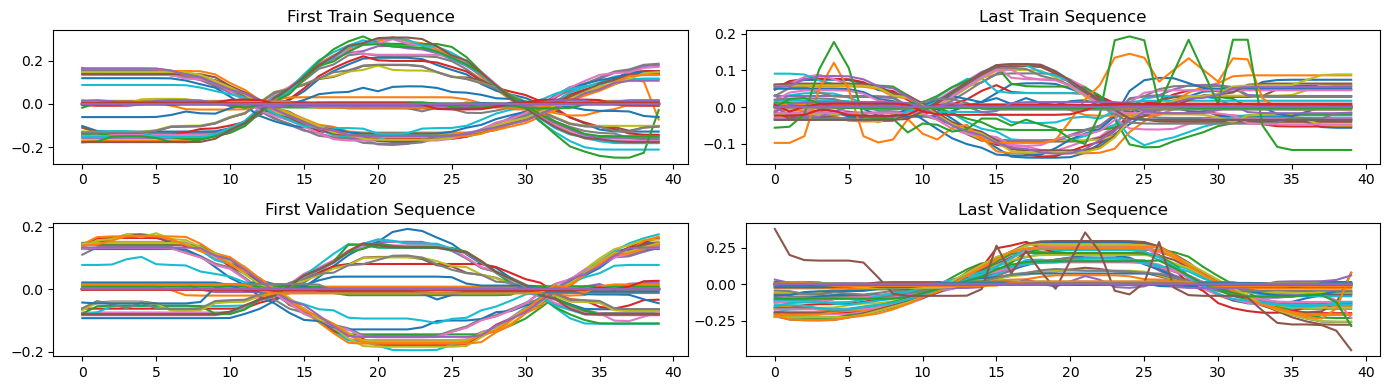

In [6]:
# Plot the first and last sequence in the training and validation sets
plt.figure(figsize = (14,4))
plt.subplot(2,2,1)
plt.plot(train_x[0])
plt.title('First Train Sequence')
plt.subplot(2,2,2)
plt.plot(train_x[-1])
plt.title('Last Train Sequence')
plt.subplot(2,2,3)
plt.plot(valid_x[0])
plt.title('First Validation Sequence')
plt.subplot(2,2,4)
plt.plot(valid_x[-1])
plt.title('Last Validation Sequence')
plt.tight_layout()
plt.show()

In [7]:
# Reduce the data length by a factor of 2, 4, and 8 
# The reduced sequences will be used as inputs to the temporal pyramid subnetwork
train_x_2 = np.zeros((train_x.shape[0], int(train_x.shape[1]/2), train_x.shape[2]))
valid_x_2 = np.zeros(train_x_2.shape)
train_x_4 = np.zeros((train_x.shape[0], int(train_x.shape[1]/4), train_x.shape[2]))
valid_x_4 = np.zeros(train_x_4.shape)
train_x_8 = np.zeros((train_x.shape[0], int(train_x.shape[1]/8), train_x.shape[2]))
valid_x_8 = np.zeros(train_x_8.shape)
train_x_2 = train_x[:,::2,:]
valid_x_2 = valid_x[:,::2,:]
train_x_4 = train_x[:,::4,:]
valid_x_4 = valid_x[:,::4,:]
train_x_8 = train_x[:,::8,:]
valid_x_8 = valid_x[:,::8,:]  

In [8]:
# Code to re-order the 117 dimensional skeleton data from the Vicon optical tracker into trunk, left arm, right arm, left leg and right leg
def reorder_data(x):
    X_trunk = np.zeros((x.shape[0], x.shape[1], 27))
    X_left_arm = np.zeros((x.shape[0], x.shape[1], 9))
    X_right_arm = np.zeros((x.shape[0], x.shape[1], 9))
    X_left_leg = np.zeros((x.shape[0], x.shape[1], 18))
    X_right_leg = np.zeros((x.shape[0], x.shape[1], 18))

   
    #X_trunk =  np.concatenate((x[:,:,15:18], x[:,:,6:9]), axis = 2)
    #trunk = Lear, Rear, Leye, Reye, nose, neck, LShold, RShoulder, MidHip
    X_trunk = np.concatenate((x[:,:,54:57], x[:,:,51:54], x[:,:,48:51], x[:,:,45:48], x[:,:,0:3], x[:,:,3:6], x[:,:,15:18], x[:,:,6:9], x[:,:,24:27]), axis = 2)
    
    #No radius, Upperhand or hand joints for arms
    #LShould, LElbow, LWrist
    X_left_arm = np.concatenate((x[:,:,15:18], x[:,:,18:21], x[:,:,21:24]), axis = 2)
    #RShould, RElbow, RWirst
    X_right_arm = np.concatenate((x[:,:,6:9], x[:,:,9:12], x[:,:,12:15]), axis = 2)  

    #no right/left pelivis, femur, tibia for legs
    #LHip, LKnee, LAnkle, LHeel
    X_left_leg = np.concatenate((x[:,:,36:39], x[:,:,39:42], x[:,:,42:45], x[:,:,63:66], x[:,:,57:60], x[:,:,60:63]), axis = 2)
    #RHip, RKnee, RAnkle, RHeel
    X_right_leg = np.concatenate((x[:,:,27:30], x[:,:,30:33], x[:,:,33:36], x[:,:,72:75], x[:,:,66:69], x[:,:,69:72]), axis = 2)
    x_segmented = np.concatenate((X_trunk, X_right_arm, X_left_arm, X_right_leg, X_left_leg), axis = -1)
    return x_segmented

In [9]:
# Reorder the data dimensions to correspond to the five body parts
trainx =  reorder_data(train_x)
validx =  reorder_data(valid_x)
trainx_2 =  reorder_data(train_x_2)
validx_2 =  reorder_data(valid_x_2)
trainx_4 =  reorder_data(train_x_4)
validx_4 =  reorder_data(valid_x_4)
trainx_8 =  reorder_data(train_x_8)
validx_8 =  reorder_data(valid_x_8)

In [10]:
# Define a multibranch convolutional Inception-like block
def MultiBranchConv1D(input, filters1, kernel_size1, strides1, strides2):
    x1 = Conv1D(filters=filters1, kernel_size=kernel_size1+2, strides=strides1, padding='same', activation='relu')(input)
    x1 = Dropout(0.25)(x1)
    x2 = Conv1D(filters=filters1, kernel_size=kernel_size1+6, strides=strides1, padding='same', activation='relu')(input)
    x2 = Dropout(0.25)(x2)
    x3 = Conv1D(filters=filters1, kernel_size=kernel_size1+12, strides=strides1, padding='same', activation='relu')(input)
    x3 = Dropout(0.25)(x3)
    y1 = concatenate([x1, x2, x3], axis=-1)

    x4 = Conv1D(filters=filters1, kernel_size=kernel_size1, strides=strides2, padding='same', activation='relu')(y1)
    x4 = Dropout(0.25)(x4)
    x5 = Conv1D(filters=filters1, kernel_size=kernel_size1+2, strides=strides2, padding='same', activation='relu')(y1)
    x5 = Dropout(0.25)(x5)
    x6 = Conv1D(filters=filters1, kernel_size=kernel_size1+4, strides=strides2, padding='same', activation='relu')(y1)
    x6 = Dropout(0.25)(x6)
    x = concatenate([x4, x5, x6], axis=-1)                                                                                                                                   
    return x

In [11]:
# Define a temporal pyramid network
def TempPyramid(input_f, input_2, input_4, input_8, seq_len, n_dims):
    
    #### Full scale sequences
    conv1 = MultiBranchConv1D(input_f, 64, 3, 2, 2)

    #### Half scale sequences
    conv2 = MultiBranchConv1D(input_2, 64, 3, 2, 1)

    #### Quarter scale sequences
    conv3 = MultiBranchConv1D(input_4, 64, 3, 1, 1)

    #### Eighth scale sequences
    conv4 = MultiBranchConv1D(input_8, 64, 3, 1, 1)
    upsample1 = UpSampling1D(size = 2)(conv4)

    #### Recurrent layers
    x = concatenate([conv1, conv2, conv3, upsample1], axis=-1)
    return x    

In [12]:
#n_dim = 48 # dimension after segmenting the data into body parts
#n_dim1 = 6 # trunk dimension
n_dim = 81
n_dim1 = 27
n_dim2 = 9 # arms dimension
n_dim3 = 18 # legs dimension

# Build the model ...

#### Full scale sequences
seq_input = Input(shape = (timesteps, n_dim), name = 'full_scale')

'''
seq_input_trunk = Lambda(lambda x: x[:, :, 0:6])(seq_input)
seq_input_left_arm = Lambda(lambda x: x[:, :, 6:15])(seq_input)
seq_input_right_arm = Lambda(lambda x: x[:, :, 15:24])(seq_input)
seq_input_left_leg = Lambda(lambda x: x[:, :, 24:36])(seq_input)
seq_input_right_leg = Lambda(lambda x: x[:, :, 36:48])(seq_input)
'''

seq_input_trunk = Lambda(lambda x: x[:, :, 0:27])(seq_input)
seq_input_left_arm = Lambda(lambda x: x[:, :, 27:36])(seq_input)
seq_input_right_arm = Lambda(lambda x: x[:, :, 36:45])(seq_input)
seq_input_left_leg = Lambda(lambda x: x[:, :, 45:63])(seq_input)
seq_input_right_leg = Lambda(lambda x: x[:, :, 63:81])(seq_input)

#### Half scale sequences
seq_input_2 = Input(shape=(int(timesteps/2), n_dim), name='half_scale')

seq_input_trunk_2 = Lambda(lambda x: x[:, :, 0:27])(seq_input_2)
seq_input_left_arm_2 = Lambda(lambda x: x[:, :, 27:36])(seq_input_2)
seq_input_right_arm_2 = Lambda(lambda x: x[:, :, 36:45])(seq_input_2)
seq_input_left_leg_2 = Lambda(lambda x: x[:, :, 45:63])(seq_input_2)
seq_input_right_leg_2 = Lambda(lambda x: x[:, :, 63:81])(seq_input_2)

#### Quarter scale sequences
seq_input_4 = Input(shape=(int(timesteps/4), n_dim), name='quarter_scale')

seq_input_trunk_4 = Lambda(lambda x: x[:, :, 0:27])(seq_input_4)
seq_input_left_arm_4 = Lambda(lambda x: x[:, :, 27:36])(seq_input_4)
seq_input_right_arm_4 = Lambda(lambda x: x[:, :, 36:45])(seq_input_4)
seq_input_left_leg_4 = Lambda(lambda x: x[:, :, 45:63])(seq_input_4)
seq_input_right_leg_4 = Lambda(lambda x: x[:, :, 63:81])(seq_input_4)

#### Eighth scale sequences
seq_input_8 = Input(shape=(int(timesteps/8), n_dim), name='eighth_scale')

seq_input_trunk_8 = Lambda(lambda x: x[:, :, 0:27])(seq_input_8)
seq_input_left_arm_8 = Lambda(lambda x: x[:, :, 27:36])(seq_input_8)
seq_input_right_arm_8 = Lambda(lambda x: x[:, :, 36:45])(seq_input_8)
seq_input_left_leg_8 = Lambda(lambda x: x[:, :, 45:63])(seq_input_8)
seq_input_right_leg_8 = Lambda(lambda x: x[:, :, 63:81])(seq_input_8)

concat_trunk = TempPyramid(seq_input_trunk, seq_input_trunk_2, seq_input_trunk_4, seq_input_trunk_8, timesteps, n_dim1)
concat_left_arm = TempPyramid(seq_input_left_arm, seq_input_left_arm_2, seq_input_left_arm_4, seq_input_left_arm_8, timesteps, n_dim2)
concat_right_arm = TempPyramid(seq_input_right_arm, seq_input_right_arm_2, seq_input_right_arm_4, seq_input_right_arm_8, timesteps, n_dim2)
concat_left_leg = TempPyramid(seq_input_left_leg, seq_input_left_leg_2, seq_input_left_leg_4, seq_input_left_leg_8, timesteps, n_dim3)
concat_right_leg = TempPyramid(seq_input_right_leg, seq_input_right_leg_2, seq_input_right_leg_4, seq_input_right_leg_8, timesteps, n_dim3)

concat = concatenate([concat_trunk, concat_left_arm, concat_right_arm, concat_left_leg, concat_right_leg], axis=-1)

#not sure what these are numbers are from?
rec = LSTM(80, return_sequences=True)(concat)
rec1 = LSTM(40, return_sequences=True)(rec)
rec1 = LSTM(40, return_sequences=True)(rec1)
rec2 = LSTM(80)(rec1)

out = Dense(1, activation = 'tanh')(rec2)

model = Model(inputs=[seq_input, seq_input_2, seq_input_4, seq_input_8], outputs=out)

model.compile(loss='binary_crossentropy', optimizer= Adam(learning_rate= 0.001))

In [13]:
t = now()
    
early_stopping = EarlyStopping(monitor='val_loss', patience = 25)

history = model.fit([trainx, trainx_2, trainx_4, trainx_8], train_y, batch_size = 16, epochs = 500, verbose=0, 
                validation_data=([validx, validx_2, validx_4, validx_8], valid_y), callbacks = [early_stopping])

print('Training time: %s' % (now() - t))

Training time: 0:04:54.096199


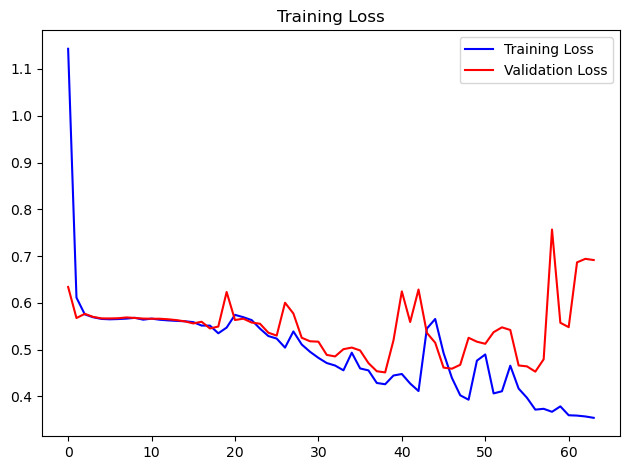

Training loss 0.35410767793655396
Validation loss 0.45121854543685913


In [14]:
# Plot the results
plt.figure(1)
plt.plot(history.history['loss'], 'b', label = 'Training Loss')
plt.title('Training Loss')
plt.plot(history.history['val_loss'], 'r', label = 'Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Print the minimum loss
print("Training loss", np.min(history.history['loss']))
print("Validation loss",np.min(history.history['val_loss']))    

2/2 [==============================] - 0s 78ms/step


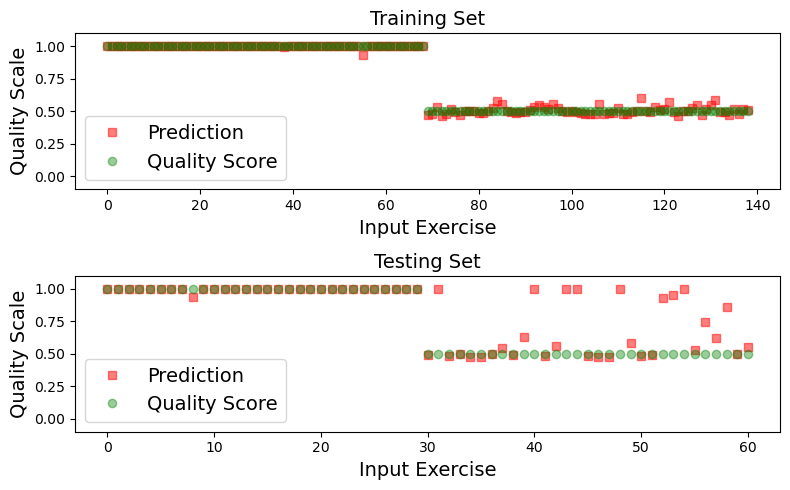

In [15]:
# Plot the prediction of the model for the training and validation sets
pred_train = model.predict([trainx, trainx_2, trainx_4, trainx_8])

pred_test = model.predict([validx, validx_2, validx_4, validx_8])

plt.figure(figsize = (8,5))
plt.subplot(2,1,1)
plt.plot(pred_train,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
plt.plot(train_y,'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
plt.ylim([-0.1,1.1])
plt.title('Training Set',fontsize=14)
plt.xlabel('Input Exercise',fontsize=14)
plt.ylabel('Quality Scale',fontsize=14)
plt.legend(loc=3, prop={'size':14}) # loc:position
plt.subplot(2,1,2)
plt.plot(pred_test,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
plt.plot(valid_y,'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
plt.title('Testing Set',fontsize=14)
plt.ylim([-0.1,1.1])
plt.xlabel('Input Exercise',fontsize=14)
plt.ylabel('Quality Scale',fontsize=14)
plt.legend(loc=3, prop={'size':14}) # loc:position
plt.tight_layout()
#plt.savefig('../../Results/SpatioTemporalNN_Vicon_Scores.png', dpi=300)
plt.show()

In [16]:
# Calculate the cumulative deviation and rms deviation for the validation set
test_dev = abs(np.squeeze(pred_test)-valid_y)
# Cumulative deviation
mean_abs_dev = np.mean(test_dev)
# RMS deviation
rms_dev = sqrt(mean_squared_error(pred_test, valid_y))
print('Mean absolute deviation:', mean_abs_dev)
print('RMS deviation:', rms_dev)

Mean absolute deviation: 0.08651068366941858
RMS deviation: 0.18698037293110725


In [17]:
import pandas as pd



#Unit test, import videos of self doing exercise and produce accuracy score on trained model
def userTest(filename):
    
    n = 75
    
    f = open(filename, 'r')
    c = csv.reader(f, delimiter = ',', quoting = csv.QUOTE_NONE)
    ctrain_x = np.zeros(shape = (1, timesteps, n))
    
    i = 0
    for row in c:
        ctrain_x[0, :, i % 75] = row
        i += 1

    #print(ctrain_x.shape)

    f.close()
    
    ctrain_x_2 = np.zeros((ctrain_x.shape[0], int(ctrain_x.shape[1]/2), ctrain_x.shape[2]))
    ctrain_x_4 = np.zeros((ctrain_x.shape[0], int(ctrain_x.shape[1]/4), ctrain_x.shape[2]))
    ctrain_x_8 = np.zeros((ctrain_x.shape[0], int(ctrain_x.shape[1]/8), ctrain_x.shape[2]))
    ctrain_x_2 = ctrain_x[:,::2,:]
    ctrain_x_4 = ctrain_x[:,::4,:]
    ctrain_x_8 = ctrain_x[:,::8,:] 
    
    #print(ctrain_x_8)

    # Reorder the data dimensions to correspond to the five body parts
    ctrainx =  reorder_data(ctrain_x)
    ctrainx_2 =  reorder_data(ctrain_x_2)
    ctrainx_4 =  reorder_data(ctrain_x_4)
    ctrainx_8 =  reorder_data(ctrain_x_8) 
    
    #print(ctrainx.shape, ctrain_x_2.shape, ctrain_x_4.shape, ctrain_x_4.shape)

    #prediction
    pred = model.predict([ctrainx, ctrainx_2, ctrainx_4, ctrainx_8])
    #print(type(pred))
    print("Your accuracy rating for " + filename + " is: ", pred)
    #print(pred[0, 0])
    return pred[0, 0]
    #plt.plot(pred,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)


1/1 [==============================] - 0s 172ms/step
Your accuracy rating for C:\Users\Molly Meadows\OneDrive - University of Idaho\Documents\2023-2024\Capstone Project\26-Physical-Rehabilitation\LungeAndShoulderSegmentedVideos\InLungeTest\same_size_csvs\\C_SL_e0_smoothed.csv is:  [[0.9998403]]
1/1 [==============================] - 0s 141ms/step
Your accuracy rating for C:\Users\Molly Meadows\OneDrive - University of Idaho\Documents\2023-2024\Capstone Project\26-Physical-Rehabilitation\LungeAndShoulderSegmentedVideos\InLungeTest\same_size_csvs\\C_SL_e1_smoothed.csv is:  [[0.9999125]]
1/1 [==============================] - 0s 156ms/step
Your accuracy rating for C:\Users\Molly Meadows\OneDrive - University of Idaho\Documents\2023-2024\Capstone Project\26-Physical-Rehabilitation\LungeAndShoulderSegmentedVideos\InLungeTest\same_size_csvs\\C_SL_e2_smoothed.csv is:  [[0.9999112]]
1/1 [==============================] - 0s 109ms/step
Your accuracy rating for C:\Users\Molly Meadows\OneDrive - 

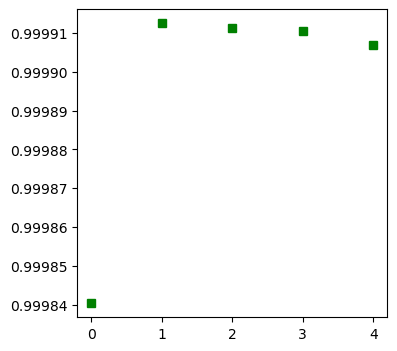

In [18]:
fig = plt.figure(figsize =(4, 4))

#store scores of good squats
good = []

#directory where testing files are stored
dir_path = r"C:\Users\Molly Meadows\OneDrive - University of Idaho\Documents\2023-2024\Capstone Project\26-Physical-Rehabilitation\LungeAndShoulderSegmentedVideos\InLungeTest\same_size_csvs\\"

G_squat = []

good.append(userTest(dir_path + "C_SL_e0_smoothed.csv"))
good.append(userTest(dir_path + "C_SL_e1_smoothed.csv"))
good.append(userTest(dir_path + "C_SL_e2_smoothed.csv"))
good.append(userTest(dir_path + "C_SL_e3_smoothed.csv"))
good.append(userTest(dir_path + "C_SL_e4_smoothed.csv"))
#print(f)


# Creating plot
plt.plot(good, 's', color = 'green', label = "Correct Side Lunge Prediction",  linestyle = 'None')









In [19]:
userTest(r"C:\Users\Molly Meadows\OneDrive - University of Idaho\Documents\2023-2024\Capstone Project\Retest of videos\same_size_csvs\MollyGoodSquat_smoothed.csv")

1/1 [==============================] - 0s 156ms/step
Your accuracy rating for C:\Users\Molly Meadows\OneDrive - University of Idaho\Documents\2023-2024\Capstone Project\Retest of videos\same_size_csvs\MollyGoodSquat_smoothed.csv is:  [[0.4877276]]


0.4877276

In [20]:
print(len(good))

5


1/1 [==============================] - 0s 62ms/step
Your accuracy rating for C:\Users\Molly Meadows\OneDrive - University of Idaho\Documents\2023-2024\Capstone Project\26-Physical-Rehabilitation\LungeAndShoulderSegmentedVideos\InLungeTest\same_size_csvs\\I_SL_e0_smoothed.csv is:  [[0.9998572]]
1/1 [==============================] - 0s 109ms/step
Your accuracy rating for C:\Users\Molly Meadows\OneDrive - University of Idaho\Documents\2023-2024\Capstone Project\26-Physical-Rehabilitation\LungeAndShoulderSegmentedVideos\InLungeTest\same_size_csvs\\I_SL_e1_smoothed.csv is:  [[0.5055654]]
1/1 [==============================] - 0s 125ms/step
Your accuracy rating for C:\Users\Molly Meadows\OneDrive - University of Idaho\Documents\2023-2024\Capstone Project\26-Physical-Rehabilitation\LungeAndShoulderSegmentedVideos\InLungeTest\same_size_csvs\\I_SL_e1_smoothed.csv is:  [[0.5055654]]
1/1 [==============================] - 0s 172ms/step
Your accuracy rating for C:\Users\Molly Meadows\OneDrive - U

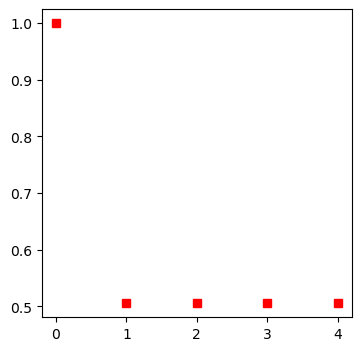

In [21]:
fig = plt.figure(figsize =(4, 4))

#store scores of good squats
bad = []

#directory where testing files are stored
dir_path = r"C:\Users\Molly Meadows\OneDrive - University of Idaho\Documents\2023-2024\Capstone Project\26-Physical-Rehabilitation\LungeAndShoulderSegmentedVideos\InLungeTest\same_size_csvs\\"
B_squat = []

bad.append(userTest(dir_path + "I_SL_e0_smoothed.csv"))
bad.append(userTest(dir_path + "I_SL_e1_smoothed.csv"))
bad.append(userTest(dir_path + "I_SL_e1_smoothed.csv"))
bad.append(userTest(dir_path + "I_SL_e1_smoothed.csv"))
bad.append(userTest(dir_path + "I_SL_e1_smoothed.csv"))

# Creating plot
plt.plot(bad, 's', color = 'red', label = "Incorrect Side Lunge Predictions",  linestyle = 'None')

In [22]:
#model.save("my_models.OpenPose_SpatioTemporalNN_Vicon_Final_Reshaped_2.h5")

In [23]:
'''
test = pd.read_csv(filename, header=None)
    test = test.to_numpy()
    
    test = np.swapaxes(test, 1, 0)

    
    ctrain_x = np.reshape(test, (1, 40, 75))
'''

'\ntest = pd.read_csv(filename, header=None)\n    test = test.to_numpy()\n    \n    test = np.swapaxes(test, 1, 0)\n\n    \n    ctrain_x = np.reshape(test, (1, 40, 75))\n'